# Model validation strategy (Ka band only linear regression)
Using MODIS IGBP landcover classes and their percentages aggregated into the Windsat Equal degrees grid

In [1]:
#
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import sys
import os

sys.path.append("../..")

from matplotlib.colors import CenteredNorm
from sklearn.metrics import mean_squared_error
from scipy.stats import kstest

from src.processing import windsat_datacube, model_preprocess
# Files
igbpMajority_path = "../../data/processed/regridded.h5"
igbpPercentaje_path = "../../data/processed/reprojected_igbp_percent_wsgrid.h5"

### Pixel selection for IGBP classes

For each class "C":  
select all pixels that are class C that also have a percentaje over 70 %  

count the number of selected pixels, discard classes like "water", "urban" and so on


In [2]:
# Load both datasets 
igbp_ds = xr.open_dataset(igbpMajority_path)
igbp_p = xr.open_dataset(igbpPercentaje_path)

# Add the percentaje array and close its file
igbp_ds["IGBP_percent"] = igbp_p.Land_Cover_Type_1_Percent
igbp_p.close()

# Central longitude is 180 deg on a 1/4 deg. grid
igbp_ds = igbp_ds.roll({
    "x" : 180 * 4
})

In [3]:
# Select the layers
igbp = igbp_ds["IGBP"]
igbp_percent = igbp_ds["IGBP_percent"]

# create the new layer with nan values
valid_pixels = np.full(igbp_ds.IGBP.shape,np.nan)

# Threshold is 70% of the pixel
threshold = 70

# Create a mask for each class, set the value of the array to the class
for i in range(igbp_percent.shape[0]):
    mask = igbp_percent[i,:,:] > threshold
    valid_pixels[mask] = i

    
# Cast the array into a new dataArray
valid_pixels_darr = xr.DataArray(valid_pixels, dims=['y', 'x'], coords={'y': igbp_ds.y, 'x': igbp_ds.x}, name='IGBP_threshold')

# Add it to the original Dataset
igbp_ds["IGBP_threshold"] = valid_pixels_darr


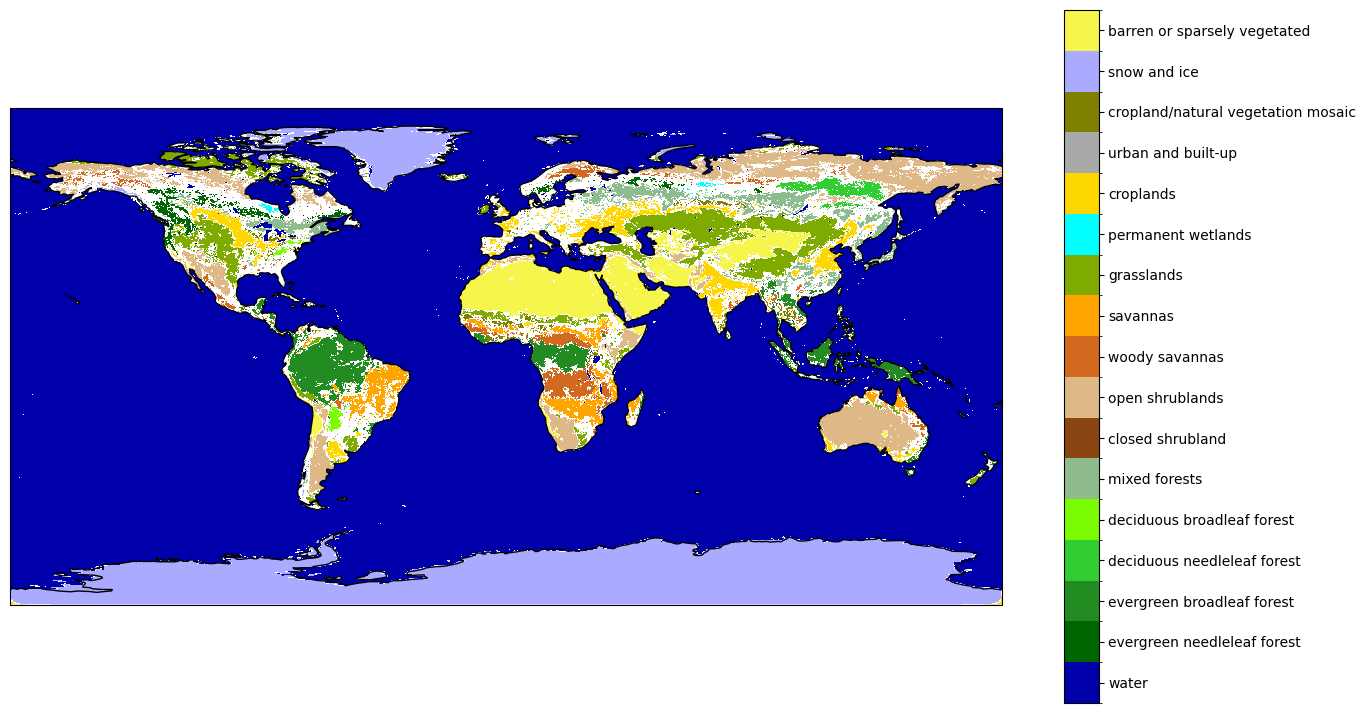

In [4]:
# custom Cmap 
custon_cmap = {
    'water': '#0000AA',
    'evergreen needleleaf forest': '#006400',
    'evergreen broadleaf forest': '#228B22',
    'deciduous needleleaf forest': '#32CD32',
    'deciduous broadleaf forest': '#7CFC00',
    'mixed forests': '#8FBC8F',
    'closed shrubland': '#8B4513',
    'open shrublands': '#DEB887',
    'woody savannas': '#D2691E',
    'savannas': '#FFA500',
    'grasslands': '#7FAA00',
    'permanent wetlands': '#00FFFF',
    'croplands': '#FFD700',
    'urban and built-up': '#A9A9A9',
    'cropland/natural vegetation mosaic': '#808000',
    'snow and ice': '#AAAAFF',
    'barren or sparsely vegetated': '#f5f54c', # changed, too close to white (nans)
}
cmap = mcolors.ListedColormap(list(custon_cmap.values()), name='land_cover')

fig, ax = plt.subplots(1,1,figsize = (16,9), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)})
ax.coastlines("110m")


# Create a normalization object
norm = mcolors.BoundaryNorm(np.arange(len(custon_cmap) + 1) - 0.5, len(custon_cmap))

# Create colorbar with custom ticks and labels
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', pad=0.05)
cbar.set_ticks(np.arange(len(custon_cmap)))
cbar.set_ticklabels(list(custon_cmap.keys()))

# Plot the map
igbp_ds.IGBP_threshold.plot(ax = ax, add_colorbar=False, cmap = cmap)

# Show the plot
plt.show()

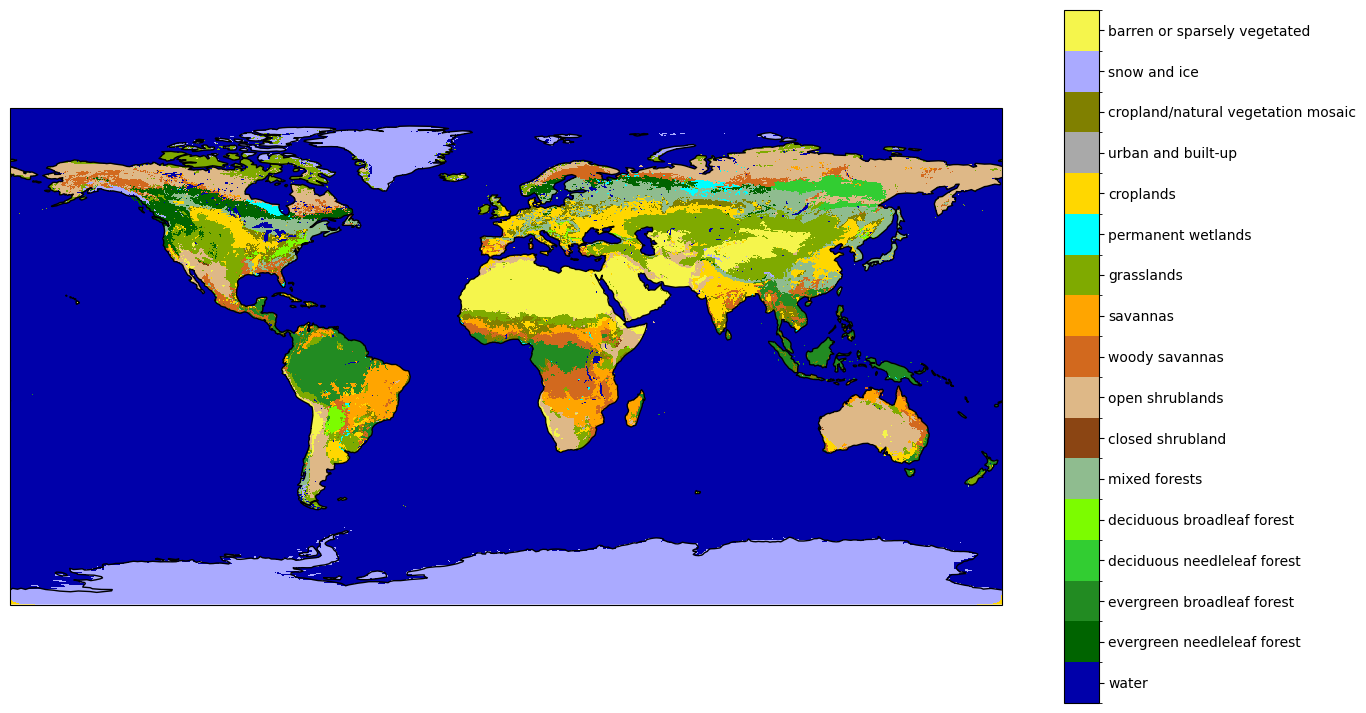

In [5]:
# Comparison with the mayotiry map:
fig, ax = plt.subplots(1,1,figsize = (16,9), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)})
ax.coastlines("110m")


# Create a normalization object
norm = mcolors.BoundaryNorm(np.arange(len(custon_cmap) + 1) - 0.5, len(custon_cmap))

# Create colorbar with custom ticks and labels
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', pad=0.05)
cbar.set_ticks(np.arange(len(custon_cmap)))
cbar.set_ticklabels(list(custon_cmap.keys()))

igbp_ds.IGBP.plot(ax = ax, add_colorbar=False, cmap = cmap)


### Get the number of pixels of each class


In [6]:

# iterate over the classes:
class_count ={i:0 for i in igbp_ds["Num_IGBP_Classes:MOD12C1"].values }
for i in class_count.keys():

    num_pixels = igbp_ds.IGBP_threshold.where(igbp_ds.IGBP_threshold == i).count(dim=["x","y"])
    class_count[i] = int(num_pixels.values)


# Translate id to class name:
name2id = {
 'water': 0,
 'evergreen needleleaf forest': 1,
 'evergreen broadleaf forest': 2,
 'deciduous needleleaf forest': 3,
 'deciduous broadleaf forest': 4,
 'mixed forests': 5,
 'closed shrubland': 6,
 'open shrublands': 7,
 'woody savannas': 8,
 'savannas': 9,
 'grasslands': 10,
 'permanent wetlands': 11,
 'croplands': 12,
 'urban and built-up': 13,
 'cropland/natural vegetation mosaic': 14,
 'snow and ice': 15,
 'barren or sparsely vegetated': 16,
 }
id2name = {v:k for k,v in name2id.items()}

# Create a dataframe to show results
dataframe_dict = {k:v for k,v in zip(name2id.keys(),class_count.values())}

df = pd.DataFrame.from_dict(dataframe_dict, orient="index").reset_index()
df.columns = ["IGBP_class",f"Valid_pixel_count: {threshold}%"]
df

,IGBP_class,Valid_pixel_count: 70%
0,water,688697
1,evergreen needleleaf forest,3361
2,evergreen broadleaf forest,14119
3,deciduous needleleaf forest,2569
4,deciduous broadleaf forest,847
5,mixed forests,9830
6,closed shrubland,4
7,open shrublands,33334
8,woody savannas,7081
9,savannas,7835


### Remove some of the classes we dont consider

In [7]:

selected_classes = [
    # 'water',
    'evergreen needleleaf forest',
    'evergreen broadleaf forest',
    'deciduous needleleaf forest',
    'deciduous broadleaf forest',
    'mixed forests',
    'closed shrubland',
    'open shrublands',
    'woody savannas',
    'savannas',
    'grasslands',
    # 'permanent wetlands',
    'croplands',
    # 'urban and built-up',
    'cropland/natural vegetation mosaic',
    # 'snow and ice',
    'barren or sparsely vegetated',
]

# Filter out classes with very low pixel count
count_threshold = 100
selected_classes = [c for c in selected_classes if class_count[name2id[c]] > count_threshold]
selected_classes

['evergreen needleleaf forest',
 'evergreen broadleaf forest',
 'deciduous needleleaf forest',
 'deciduous broadleaf forest',
 'mixed forests',
 'open shrublands',
 'woody savannas',
 'savannas',
 'grasslands',
 'croplands',
 'cropland/natural vegetation mosaic',
 'barren or sparsely vegetated']

In [8]:
# Plot the maps for all the selected classes:
# selected_darr = igbp_ds.IGBP_threshold
# for class_name in selected_classes:
#     c_id = name2id[class_name]

#     class_mask = selected_darr.where(selected_darr == c_id)

#     fig, ax = plt.subplots(1,1,figsize = (12,6), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=0)})
#     ax.coastlines("110m")

#     class_mask.plot(ax = ax, cmap=plt.cm.colors.ListedColormap(['none', custon_cmap[id2name[c_id]]]), add_colorbar = False)

#     ax.set_title(f"{class_name}")

# NEXT STEP

Load a model and run it on the test data  

General map and error histogram

Individual validation over each selected IGBP class

In [9]:
# Linear regression with the coefficients:

a = 0.56
b = 138.29
swath = 0

# a = 0.54
# b = 142.89
# swath = 1

# Load windsat data
folder_path = "../../data/raw/daily_Windsat/"

ds = windsat_datacube(folder_path)
swath_ds= model_preprocess(ds, swath_sector=swath, look="impute",add_look_flag=False)

swath_ds = swath_ds.roll({
    "longitude_grid" : 180 * 4
})

# Select the variables from windsat that we need:
swath_ds = swath_ds[["tbtoa_37Ghz_V","surtep_ERA5","lat","lon"]]

swath_ds = swath_ds.swap_dims({
    "latitude_grid": "lat",
    "longitude_grid": "lon"
})

swath_ds["lat"] = swath_ds.lat.sortby("lat")
swath_ds["lon"] = swath_ds.lon.sortby("lon")

# Apply the linear model and get the error
swath_ds["surtep_MODEL"] = swath_ds.tbtoa_37Ghz_V * a + b

swath_ds["error"] = swath_ds.surtep_ERA5 - swath_ds.surtep_MODEL

swath_ds

<xarray.Dataset> Size: 697MB
Dimensions:         (day_number: 24, lat: 720, lon: 1440)
Coordinates:
  * lat             (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon             (lon) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
    latitude_grid   (lat) int32 3kB 0 1 2 3 4 5 6 ... 714 715 716 717 718 719
    longitude_grid  (lon) int32 6kB 0 1 2 3 4 5 ... 1435 1436 1437 1438 1439
Data variables:
    tbtoa_37Ghz_V   (day_number, lat, lon) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    surtep_ERA5     (day_number, lat, lon) float32 100MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    surtep_MODEL    (day_number, lat, lon) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    error           (day_number, lat, lon) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [10]:
from matplotlib.colors import LinearSegmentedColormap
color_min    = "#ff0000"
color_center = "#BBBBBB" 
color_max    = "#0000FF"
error_cmap = LinearSegmentedColormap.from_list(
    "cmap_name",
    [color_min, color_center, color_max]
)

---
## Now, select the pixels in a class and do this all over again

In [11]:
i = 1

class_name = selected_classes[i]
class_id = name2id[class_name]

class_mask = igbp_ds.IGBP_threshold == class_id

# Align longitude to the swath dataset
class_mask = class_mask.roll({
    "x" : 180 * 4
})

# Add class mask to the swath dataframe
swath_ds["IGBP_mask"] = (("lat","lon"), class_mask.values)

# Select the swath
swath_selection = swath_ds.where(swath_ds.IGBP_mask == True)

# Drop the IGBP_mask dvar
swath_selection = swath_selection.drop_vars("IGBP_mask")

In [12]:
# Same as before with the new selection

swath_selection["surtep_MODEL"] = swath_selection.tbtoa_37Ghz_V * a + b

swath_selection["error"] = swath_selection.surtep_ERA5 - swath_selection.surtep_MODEL


In [13]:
# Other Statistics
# Remove nans from errors
error_data = swath_selection["error"].values.flatten()
error_data = error_data[~np.isnan(error_data)]

n_obs = len(error_data)

rmse = np.sqrt(((swath_selection.surtep_ERA5 - swath_selection.surtep_MODEL) ** 2).mean(skipna=True).compute())
rmse = float(rmse.values)

# Kolmogorov-Smirnov (for a normal distribution)
mean_error = float(np.mean(error_data))
std_error = float(np.std(error_data))

ks_stat, ks_p = kstest(error_data, 'norm', args=(mean_error, std_error))

# save all statins into a dataframe row
result_df = pd.DataFrame({
    'class_name': [class_name],
    'class_bias [K]': [mean_error],
    'std [K]': [std_error],
    'rmse [K]': [rmse],
    'ks_stat': [ks_stat],
    'p-value': [ks_p],
    'n_obs' : [n_obs]
})

result_df


,class_name,class_bias [K],std [K],rmse [K],ks_stat,p-value,n_obs
0,evergreen broadleaf forest,3.791174,5.323598,6.535571,0.180552,0.0,35915


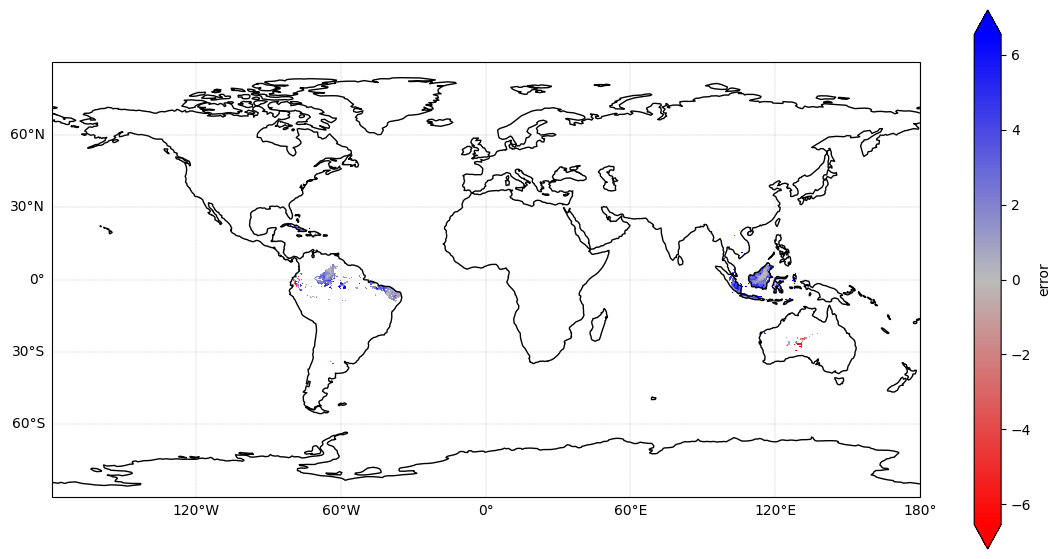

In [14]:
# MAPS
fig, ax = plt.subplots(1,1,figsize = (14,7), subplot_kw={"projection":ccrs.PlateCarree()} )

ax.coastlines("110m")

norm = CenteredNorm(vcenter=0,halfrange=rmse, clip = False)

swath_selection.error.mean(dim="day_number").plot(ax=ax,norm=norm, cmap = error_cmap)

# Add gridlines and labels
gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.9, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Display the plot
plt.show()


## House all of this into a nice function

---

Modifyed version of the function to also return the error list

In [15]:
swath_ds

<xarray.Dataset> Size: 698MB
Dimensions:         (day_number: 24, lat: 720, lon: 1440)
Coordinates:
  * lat             (lat) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon             (lon) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
    latitude_grid   (lat) int32 3kB 0 1 2 3 4 5 6 ... 714 715 716 717 718 719
    longitude_grid  (lon) int32 6kB 0 1 2 3 4 5 ... 1435 1436 1437 1438 1439
Data variables:
    tbtoa_37Ghz_V   (day_number, lat, lon) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    surtep_ERA5     (day_number, lat, lon) float32 100MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    surtep_MODEL    (day_number, lat, lon) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    error           (day_number, lat, lon) float64 199MB dask.array<chunksize=(1, 240, 480), meta=np.ndarray>
    IGBP_mask       (lat, lon) bool 1MB False False False ... False False False
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [16]:
def get_statistics(class_name: str, plot_maps: bool = False) -> pd.DataFrame:

    class_id = name2id[class_name]
    class_mask = igbp_ds.IGBP_threshold == class_id

    # Align longitude to the swath dataset
    class_mask = class_mask.roll({"x": 180 * 4})

    # Add class mask to the swath dataframe
    swath_ds["IGBP_mask"] = (("lat","lon"), class_mask.values)

    # Select the swath
    swath_selection = swath_ds.where(swath_ds.IGBP_mask == True)

    # Drop the IGBP_mask dvar
    swath_selection = swath_selection.drop_vars("IGBP_mask")

    swath_selection["surtep_MODEL"] = swath_selection.tbtoa_37Ghz_V * a + b
    swath_selection["error"] = swath_selection.surtep_MODEL - swath_selection.surtep_ERA5 

    # Remove nans from errors
    error_data = swath_selection["error"].values.flatten()
    error_data = error_data[~np.isnan(error_data)]

    n_obs = len(error_data)

    rmse = np.sqrt(((swath_selection.surtep_MODEL - swath_selection.surtep_ERA5) ** 2).mean(skipna=True).compute())
    rmse = float(rmse.values)

    # Kolmogorov-Smirnov (for a normal distribution)
    mean_error = float(np.mean(error_data))
    std_error = float(np.std(error_data))

    ks_stat, ks_p = kstest(error_data, 'norm', args=(mean_error, std_error))

    # save all statins into a dataframe row
    result_df = pd.DataFrame({
        'class_name': [class_name],
        'class_bias [K]': [mean_error],
        'std [K]': [std_error],
        'rmse [K]': [rmse],
        'ks_stat': [ks_stat],
        'p-value': [ks_p],
        'n_obs': [n_obs]
    })

    if plot_maps:
        fig, ax = plt.subplots(1, 1, figsize=(14, 7), subplot_kw={"projection": ccrs.PlateCarree()})

        ax.coastlines("10m")
        ax.set_title(f"{class_name}")

        norm = CenteredNorm(vcenter=0, halfrange=2 * rmse + abs(mean_error), clip=False)

        swath_selection.error.mean(dim="day_number").plot(ax=ax, norm=norm, cmap=error_cmap)

        # Add gridlines and labels
        gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.9, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False

        # Display the plot
        plt.show()

    return result_df, error_data


In [17]:
results_df = pd.DataFrame()
all_errors = []

for class_name in selected_classes:
    class_id = name2id[class_name]

    # Wrapper
    class_df, error_data = get_statistics(class_name, plot_maps = False)
    results_df = pd.concat([class_df, results_df], ignore_index=True)

    # Append errors with class labels
    all_errors.append(pd.DataFrame({'class_name': class_name, 'error': error_data}))

all_errors_df = pd.concat(all_errors, ignore_index=True)



In [18]:
# Create a copy and rename class_name to "All Classes", extend the full dataframe and plot

all_classes_errors_df = all_errors_df.copy()

all_classes_errors_df["class_name"] = ["All Classes" for _ in range(len(all_classes_errors_df))]

all_errors_df = pd.concat([all_errors_df, all_classes_errors_df])
all_errors_df.groupby("class_name").count()


,error
class_name,
All Classes,371717
barren or sparsely vegetated,26702
cropland/natural vegetation mosaic,4313
croplands,33126
deciduous broadleaf forest,6652
deciduous needleleaf forest,557
evergreen broadleaf forest,35915
evergreen needleleaf forest,19761
grasslands,85532


In [19]:
results_df

,class_name,class_bias [K],std [K],rmse [K],ks_stat,p-value,n_obs
0,barren or sparsely vegetated,1.221479,8.114420,8.205841,0.145693,0.000000e+00,26702
1,cropland/natural vegetation mosaic,-1.112424,8.012265,8.089120,0.057781,5.867010e-13,4313
2,croplands,0.828174,6.540315,6.592541,0.076246,6.236066e-168,33126
3,grasslands,2.307196,6.067907,6.491737,0.046962,2.312062e-164,85532
4,savannas,-2.122939,5.455970,5.854440,0.113779,8.425791e-169,14928
5,woody savannas,1.646773,6.184147,6.399651,0.071078,4.496711e-60,13573
6,open shrublands,0.803661,5.686680,5.743187,0.030771,1.961377e-84,102118
7,mixed forests,3.395346,5.808152,6.727778,0.055090,1.000369e-75,28540
8,deciduous broadleaf forest,-1.762871,6.574518,6.806762,0.064261,2.520877e-24,6652
9,deciduous needleleaf forest,-0.472508,6.039859,6.058313,0.060388,3.299798e-02,557


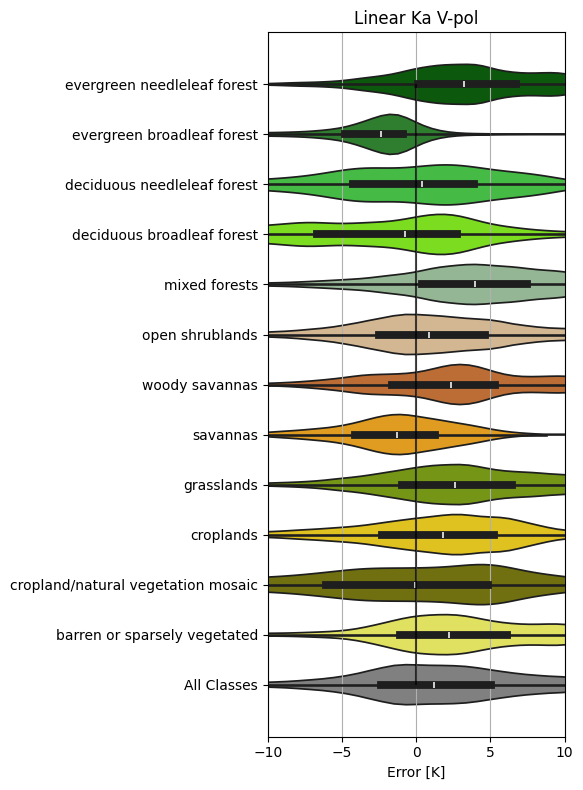

In [20]:
import seaborn as sns

plt.figure(figsize=(6, 8))
filtered_cmap = {class_name:custon_cmap[class_name] for class_name in selected_classes}

filtered_cmap["All Classes"] = "Gray"

sns.violinplot(y="class_name", x='error', data=all_errors_df,hue="class_name", palette=filtered_cmap, inner='box', density_norm='width', legend=False)

plt.ylabel('')
plt.xlabel('Error [K]')
plt.title('Linear Ka V-pol')
plt.grid(axis="x")

plt.vlines(x = 0, ymin ="All Classes", ymax = "evergreen needleleaf forest", colors= "Black" , alpha = 0.7)

plt.xlim([-10,10])
plt.tight_layout()
plt.show()


In [21]:
swath

0